# MLP
MLP, K=5, lncRNA.

Droput.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-06 14:18:43.387003


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    drop1  = Dropout(.50)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(drop1)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 14:18:45.555131
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 14:18:45.809786
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 14:19:04.629972
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 14:19:04.644003
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 14:19:04.729319


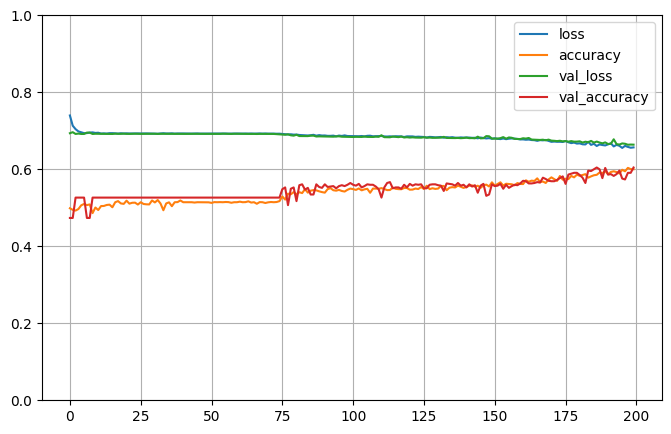


Testing # 1 1
2023-04-06 14:20:36.025115
2023-04-06 14:20:36.025615
PREDICT
2023-04-06 14:20:36.034882
Test 1:0 458:412 52.64%
Predict 1:0 510:360 58.62%
Test sizes (870, 1025) (870,)
Range of scores: 0.015283897 to 0.79244727
Score threshold 0.5
Confusion matrix
 [[214 198]
 [146 312]]
Normalized matrix
 [[0.24597701 0.22758621]
 [0.16781609 0.35862069]]


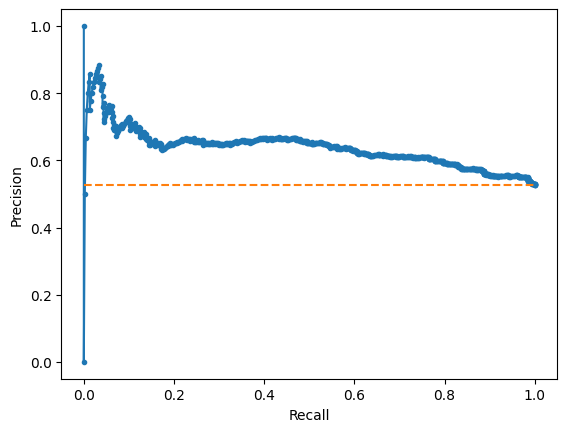

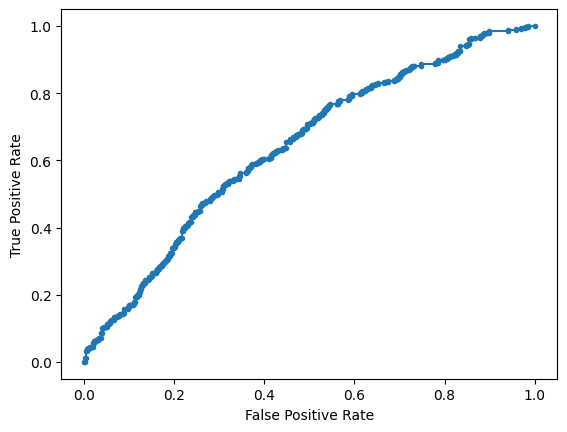

Accuracy: 60.46% Precision: 61.18% Recall: 68.12%
F1: 64.46% MCC: 0.2034
AUPRC: 63.74% AUROC: 63.94%
 accuracy [60.45977011494252]
 precision [61.1764705882353]
 recall [68.12227074235808]
 F1 [64.46280991735537]
 MCC [0.20340560879467537]
 AUPRC [63.73734560702808]
 AUROC [63.942531903167]

Training # 1 2
2023-04-06 14:20:36.739047
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 14:20:36.766165
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 14:20:36.845434


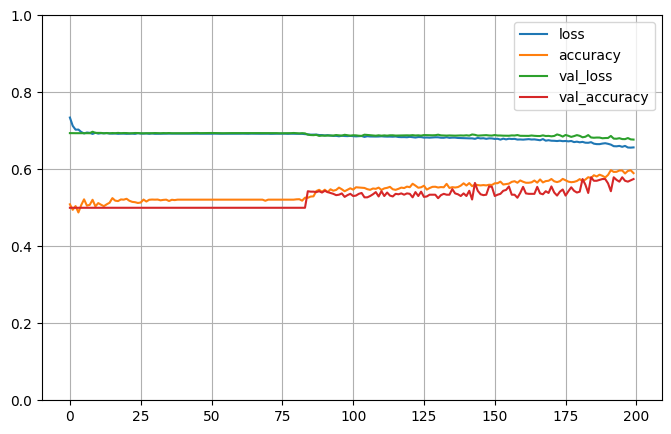


Testing # 1 2
2023-04-06 14:22:05.507722
2023-04-06 14:22:05.507977
PREDICT
2023-04-06 14:22:05.516029
Test 1:0 442:442 50.00%
Predict 1:0 584:300 66.06%
Test sizes (884, 1025) (884,)
Range of scores: 0.016593458 to 0.74951965
Score threshold 0.5
Confusion matrix
 [[183 259]
 [117 325]]
Normalized matrix
 [[0.20701357 0.29298643]
 [0.13235294 0.36764706]]


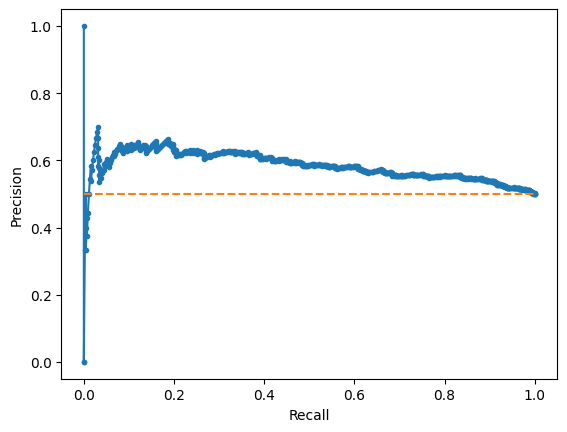

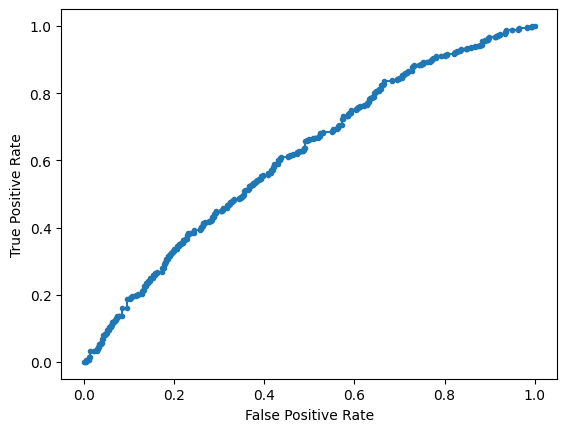

Accuracy: 57.47% Precision: 55.65% Recall: 73.53%
F1: 63.35% MCC: 0.1577
AUPRC: 58.33% AUROC: 61.36%
 accuracy [57.466063348416284]
 precision [55.650684931506845]
 recall [73.52941176470588]
 F1 [63.35282651072125]
 MCC [0.15768009924727386]
 AUPRC [58.33190819437992]
 AUROC [61.36033250752442]

Training # 1 3
2023-04-06 14:22:06.090838
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 14:22:06.107775
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 14:22:06.198660


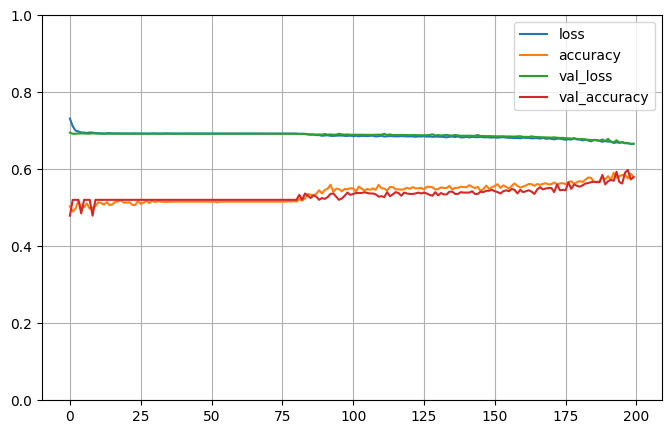


Testing # 1 3
2023-04-06 14:23:31.207292
2023-04-06 14:23:31.207352
PREDICT
2023-04-06 14:23:31.219283
Test 1:0 442:407 52.06%
Predict 1:0 655:194 77.15%
Test sizes (849, 1025) (849,)
Range of scores: 0.0960521 to 0.7096226
Score threshold 0.5
Confusion matrix
 [[122 285]
 [ 72 370]]
Normalized matrix
 [[0.14369847 0.33568905]
 [0.08480565 0.43580683]]


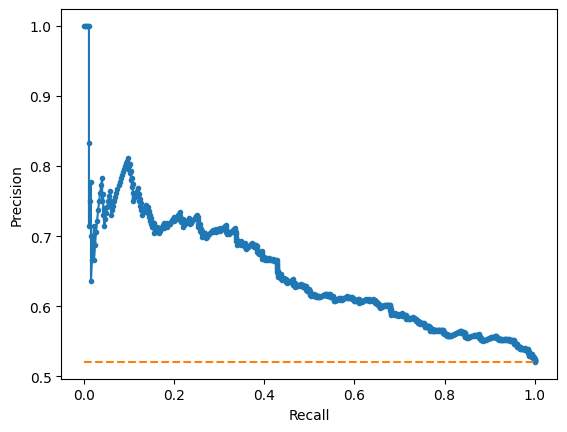

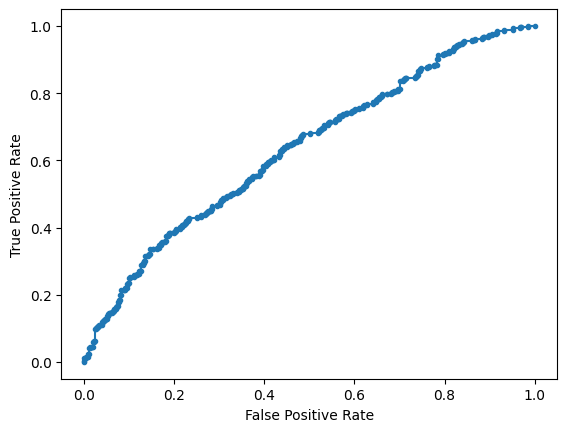

Accuracy: 57.95% Precision: 56.49% Recall: 83.71%
F1: 67.46% MCC: 0.1628
AUPRC: 64.59% AUROC: 63.35%
 accuracy [57.95053003533569]
 precision [56.48854961832062]
 recall [83.710407239819]
 F1 [67.45670009115771]
 MCC [0.1628389128799404]
 AUPRC [64.58868103730745]
 AUROC [63.35175158704571]

Training # 1 4
2023-04-06 14:23:31.792122
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 14:23:31.819601
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 14:23:31.903224


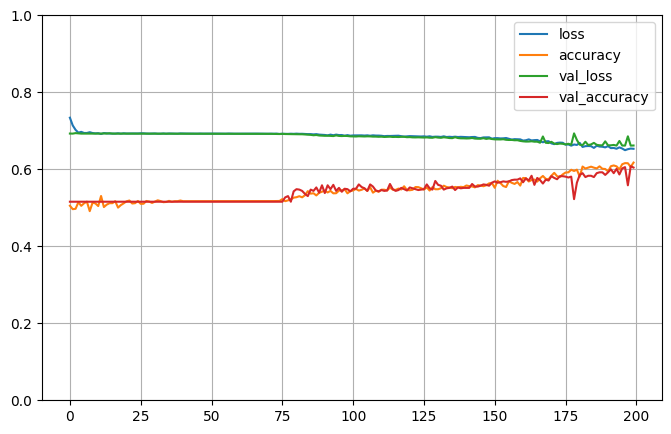


Testing # 1 4
2023-04-06 14:25:55.771642
2023-04-06 14:25:55.771689
PREDICT
2023-04-06 14:25:55.782412
Test 1:0 459:431 51.57%
Predict 1:0 537:353 60.34%
Test sizes (890, 1025) (890,)
Range of scores: 0.03010957 to 0.847667
Score threshold 0.5
Confusion matrix
 [[216 215]
 [137 322]]
Normalized matrix
 [[0.24269663 0.24157303]
 [0.15393258 0.36179775]]


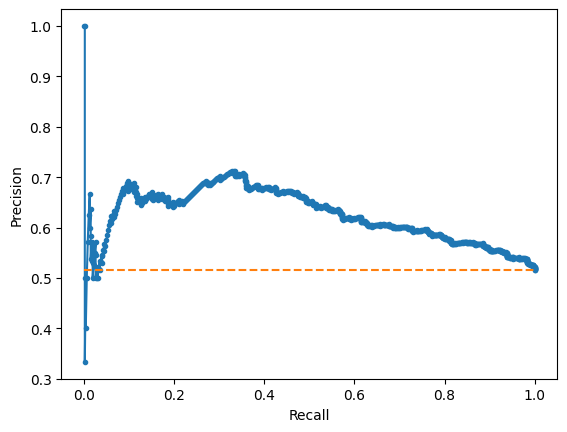

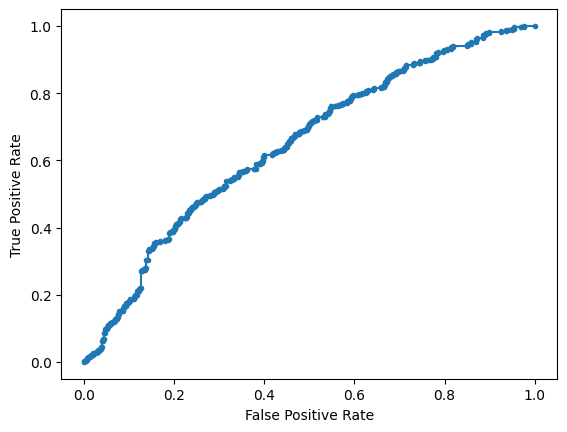

Accuracy: 60.45% Precision: 59.96% Recall: 70.15%
F1: 64.66% MCC: 0.2071
AUPRC: 62.41% AUROC: 64.72%
 accuracy [60.449438202247194]
 precision [59.96275605214153]
 recall [70.1525054466231]
 F1 [64.65863453815261]
 MCC [0.20705818706706317]
 AUPRC [62.41111130235929]
 AUROC [64.71750855536852]

Training # 1 5
2023-04-06 14:25:56.376552
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 14:25:56.409060
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 14:25:56.494777


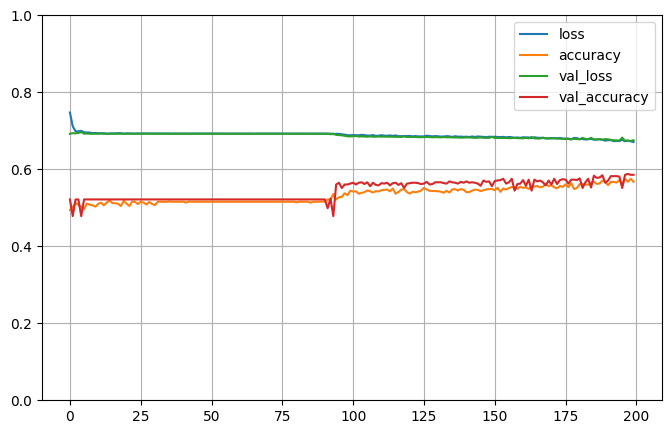


Testing # 1 5
2023-04-06 14:28:19.686459
2023-04-06 14:28:19.686507
PREDICT
2023-04-06 14:28:19.700248
Test 1:0 457:419 52.17%
Predict 1:0 526:350 60.05%
Test sizes (876, 1025) (876,)
Range of scores: 0.015565859 to 0.62432873
Score threshold 0.5
Confusion matrix
 [[203 216]
 [147 310]]
Normalized matrix
 [[0.23173516 0.24657534]
 [0.16780822 0.35388128]]


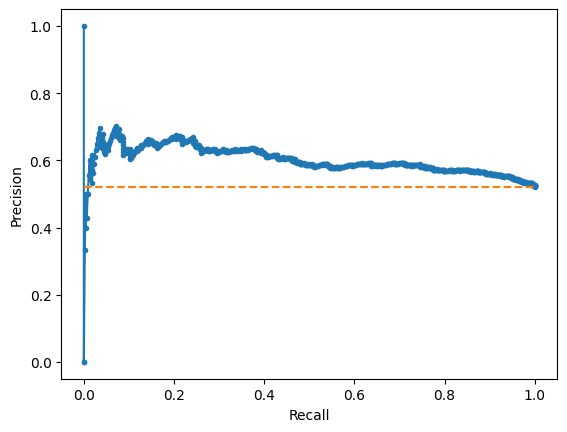

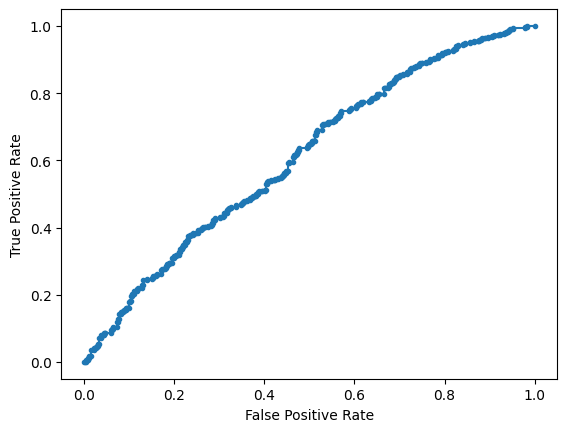

Accuracy: 58.56% Precision: 58.94% Recall: 67.83%
F1: 63.07% MCC: 0.1661
AUPRC: 60.09% AUROC: 60.96%
 accuracy [58.56164383561644]
 precision [58.935361216730044]
 recall [67.83369803063457]
 F1 [63.072227873855546]
 MCC [0.16605664030841927]
 AUPRC [60.09148309764214]
 AUROC [60.95841406286719]

Training # 2 1
2023-04-06 14:28:20.696607
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 14:28:20.720360
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 14:28:20.837815


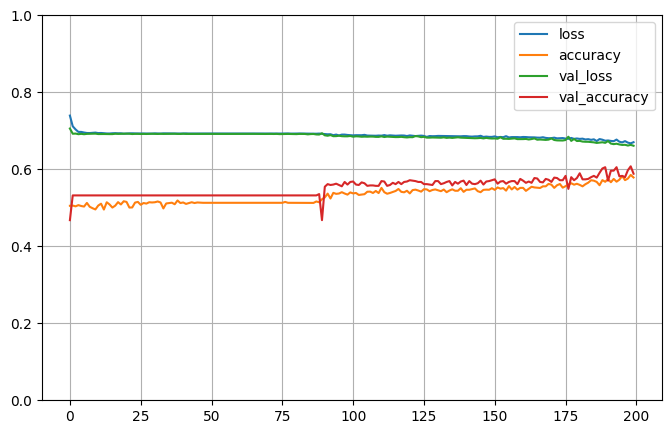


Testing # 2 1
2023-04-06 14:30:44.516798
2023-04-06 14:30:44.516855
PREDICT
2023-04-06 14:30:44.529061
Test 1:0 472:415 53.21%
Predict 1:0 695:192 78.35%
Test sizes (887, 1025) (887,)
Range of scores: 0.04146739 to 0.76098007
Score threshold 0.5
Confusion matrix
 [[121 294]
 [ 71 401]]
Normalized matrix
 [[0.13641488 0.33145434]
 [0.0800451  0.45208568]]


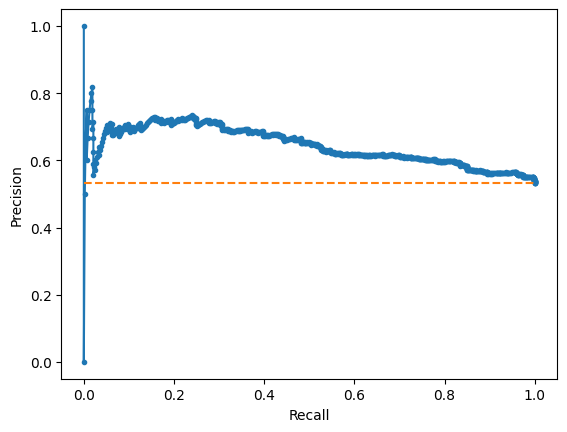

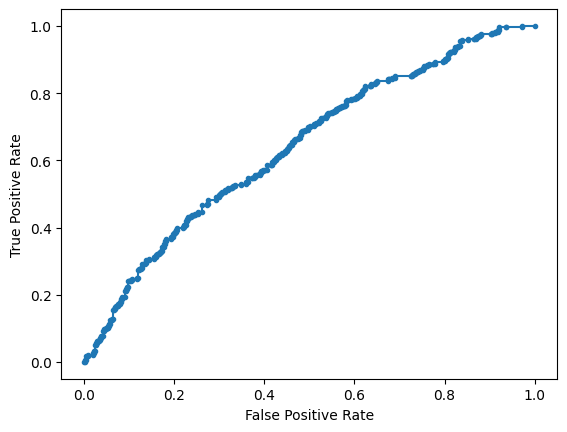

Accuracy: 58.85% Precision: 57.70% Recall: 84.96%
F1: 68.72% MCC: 0.1710
AUPRC: 64.39% AUROC: 64.05%
 accuracy [58.8500563697858]
 precision [57.697841726618705]
 recall [84.95762711864407]
 F1 [68.72322193658954]
 MCC [0.17100544861589936]
 AUPRC [64.39052747121754]
 AUROC [64.05452317745558]

Training # 2 2
2023-04-06 14:30:45.138921
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 14:30:45.161064
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 14:30:45.256699


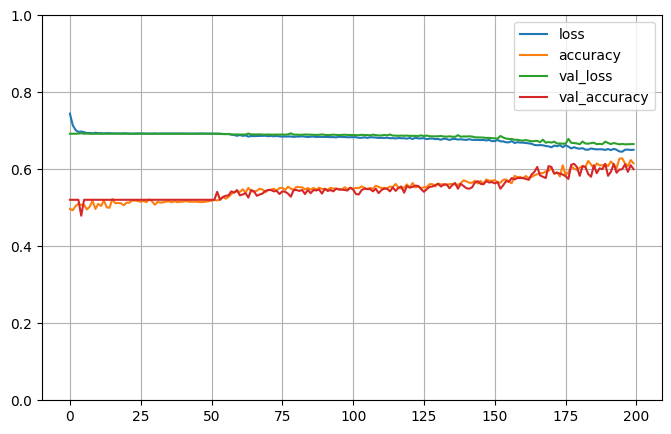


Testing # 2 2
2023-04-06 14:33:08.450926
2023-04-06 14:33:08.451391
PREDICT
2023-04-06 14:33:08.460167
Test 1:0 452:416 52.07%
Predict 1:0 581:287 66.94%
Test sizes (868, 1025) (868,)
Range of scores: 0.0061910152 to 0.81028074
Score threshold 0.5
Confusion matrix
 [[178 238]
 [109 343]]
Normalized matrix
 [[0.20506912 0.27419355]
 [0.12557604 0.39516129]]


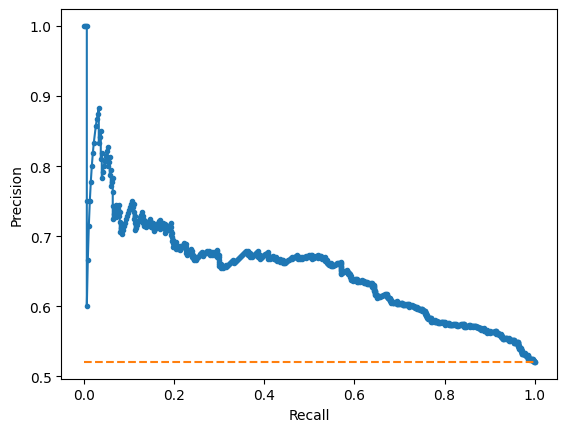

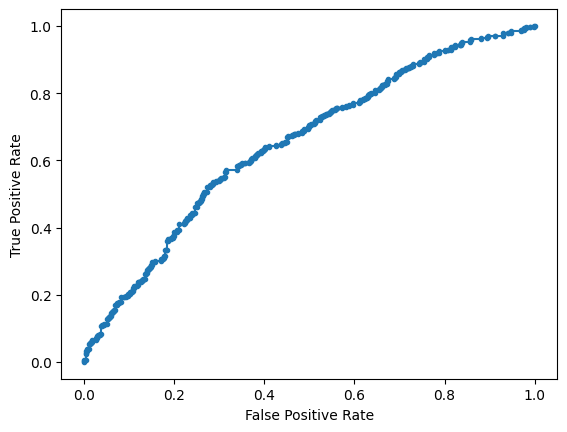

Accuracy: 60.02% Precision: 59.04% Recall: 75.88%
F1: 66.41% MCC: 0.1983
AUPRC: 65.11% AUROC: 65.00%
 accuracy [60.023041474654384]
 precision [59.036144578313255]
 recall [75.88495575221239]
 F1 [66.4085188770571]
 MCC [0.19829450091423573]
 AUPRC [65.10760719899129]
 AUROC [64.9985108917631]

Training # 2 3
2023-04-06 14:33:09.023058
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 14:33:09.048108
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 14:33:09.128098


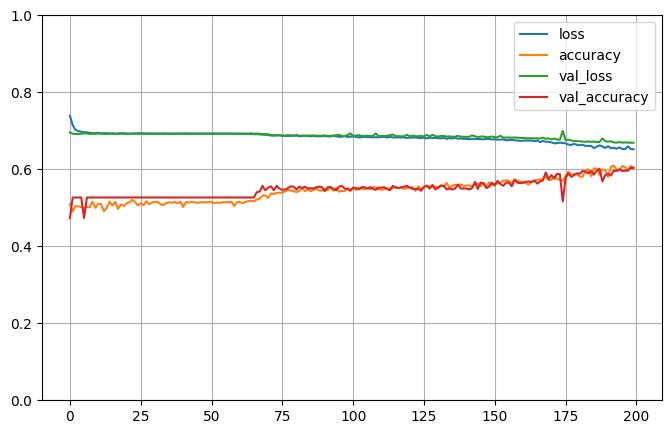


Testing # 2 3
2023-04-06 14:34:34.911063
2023-04-06 14:34:34.911553
PREDICT
2023-04-06 14:34:34.919461
Test 1:0 453:407 52.67%
Predict 1:0 646:214 75.12%
Test sizes (860, 1025) (860,)
Range of scores: 0.008520478 to 0.8133749
Score threshold 0.5
Confusion matrix
 [[140 267]
 [ 74 379]]
Normalized matrix
 [[0.1627907  0.31046512]
 [0.08604651 0.44069767]]


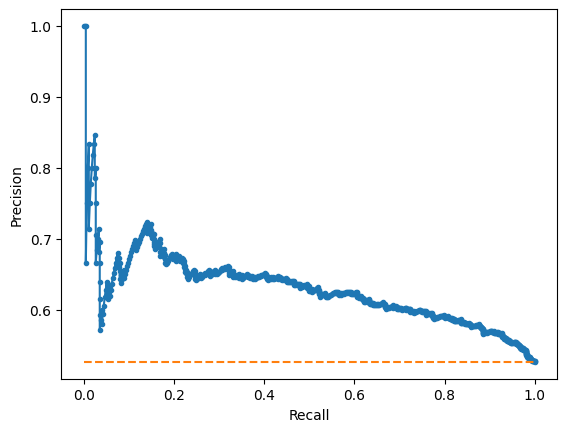

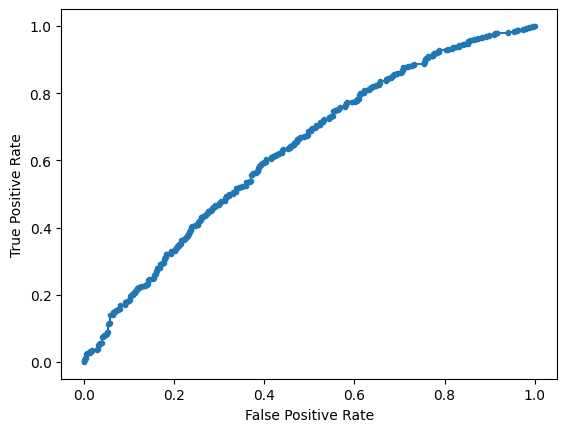

Accuracy: 60.35% Precision: 58.67% Recall: 83.66%
F1: 68.97% MCC: 0.2086
AUPRC: 62.94% AUROC: 63.16%
 accuracy [60.34883720930233]
 precision [58.6687306501548]
 recall [83.6644591611479]
 F1 [68.97179253867152]
 MCC [0.2085935451346373]
 AUPRC [62.93585972291111]
 AUROC [63.163946607655234]

Training # 2 4
2023-04-06 14:34:35.484567
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 14:34:35.513584
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 14:34:35.594695


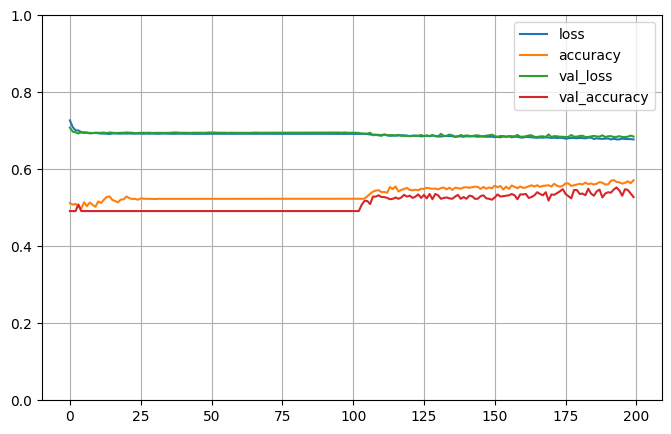


Testing # 2 4
2023-04-06 14:36:58.751458
2023-04-06 14:36:58.751506
PREDICT
2023-04-06 14:36:58.769034
Test 1:0 432:447 49.15%
Predict 1:0 539:340 61.32%
Test sizes (879, 1025) (879,)
Range of scores: 0.03310513 to 0.56510955
Score threshold 0.5
Confusion matrix
 [[186 261]
 [154 278]]
Normalized matrix
 [[0.2116041  0.29692833]
 [0.17519909 0.31626849]]


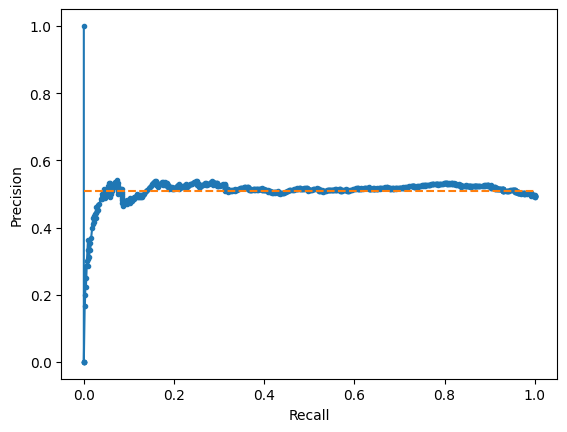

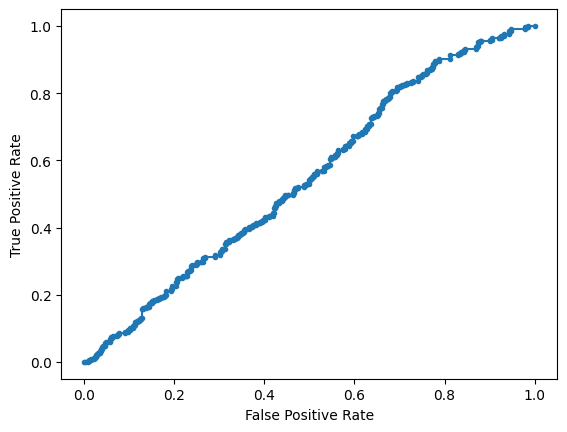

Accuracy: 52.79% Precision: 51.58% Recall: 64.35%
F1: 57.26% MCC: 0.0612
AUPRC: 51.05% AUROC: 54.79%
 accuracy [52.7872582480091]
 precision [51.57699443413729]
 recall [64.35185185185185]
 F1 [57.260556127703396]
 MCC [0.06120638771681765]
 AUPRC [51.05382235359741]
 AUROC [54.791718452233]

Training # 2 5
2023-04-06 14:36:59.352442
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 14:36:59.381890
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 14:36:59.465188


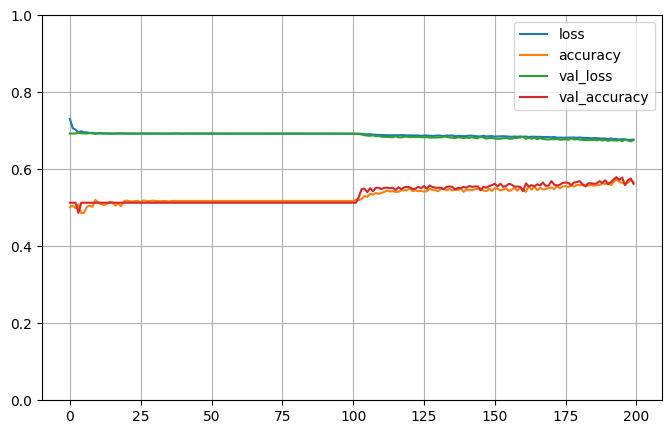


Testing # 2 5
2023-04-06 14:38:28.042920
2023-04-06 14:38:28.042965
PREDICT
2023-04-06 14:38:28.053203
Test 1:0 449:426 51.31%
Predict 1:0 766:109 87.54%
Test sizes (875, 1025) (875,)
Range of scores: 0.071494155 to 0.590809
Score threshold 0.5
Confusion matrix
 [[ 76 350]
 [ 33 416]]
Normalized matrix
 [[0.08685714 0.4       ]
 [0.03771429 0.47542857]]


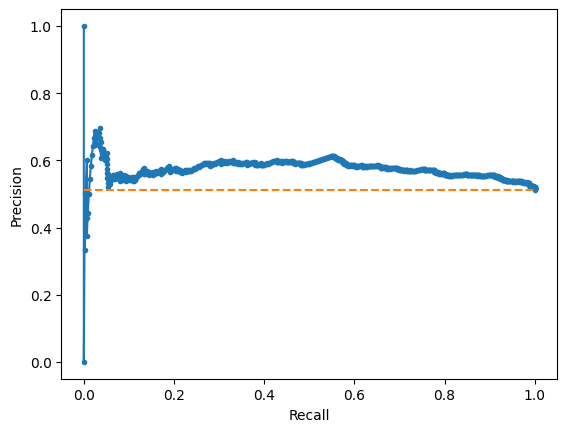

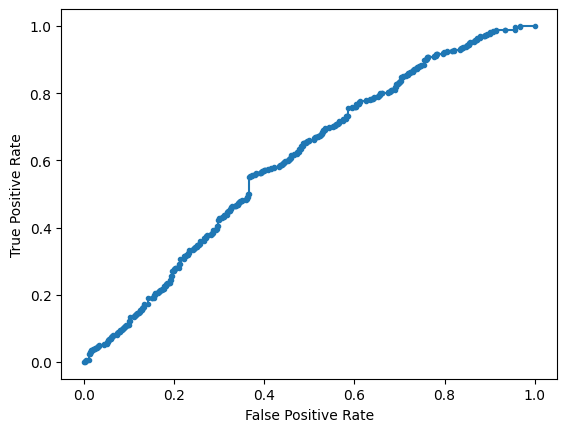

Accuracy: 56.23% Precision: 54.31% Recall: 92.65%
F1: 68.48% MCC: 0.1588
AUPRC: 57.36% AUROC: 60.10%
 accuracy [56.22857142857143]
 precision [54.308093994778076]
 recall [92.65033407572383]
 F1 [68.47736625514403]
 MCC [0.15878343908185172]
 AUPRC [57.3647881731727]
 AUROC [60.10173886675659]
2023-04-06 14:38:29.070739


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.31% std 2.41
 precision mean 57.35% std 2.88
 recall mean 76.49% std 9.30
 F1 mean 65.28% std 3.59
 MCC mean 0.17% std 0.04
 AUPRC mean 61.00% std 4.40
 AUROC mean 62.14% std 3.06
 accuracy [[60.45977011494252], [57.466063348416284], [57.95053003533569], [60.449438202247194], [58.56164383561644], [58.8500563697858], [60.023041474654384], [60.34883720930233], [52.7872582480091], [56.22857142857143]]
 precision [[61.1764705882353], [55.650684931506845], [56.48854961832062], [59.96275605214153], [58.935361216730044], [57.697841726618705], [59.036144578313255], [58.6687306501548], [51.57699443413729], [54.308093994778076]]
 recall [[68.12227074235808], [73.52941176470588], [83.710407239819], [70.1525054466231], [67.83369803063457], [84.95762711864407], [75.88495575221239], [83.6644591611479], [64.35185185185185], [92.65033407572383]]
 F1 [[64.46280991735537], [63.35282651072125], [67.45670009115771], [64.65863453815261], [63.072227873855546], [68.72322193658954], [66.4085